In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet34

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from torch.optim import SGD
from torchcp.classification.scores import APS, RAPS, SAPS, THR
from torchcp.classification.predictors import ClusterPredictor, WeightedPredictor, ClassWisePredictor, SplitPredictor

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 50
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

In [3]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define transformations for the CIFAR-100 dataset
transform_cifar100 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and load the CIFAR-100 dataset
cifar100_train_set = torchvision.datasets.CIFAR100(
    root='../data', train=True, download=True, transform=transform_cifar100
)
cifar100_test_set = torchvision.datasets.CIFAR100(
    root='../data', train=False, download=True, transform=transform_cifar100
)

# Create data loaders
cifar100_train_loader = DataLoader(cifar100_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cifar100_test_loader = DataLoader(cifar100_test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# CIFAR-100 的类名列表
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
               'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
               'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
               'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
               'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
               'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
               'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
               'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
               'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
               'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
               'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
               'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
               'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
               'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
               'worm']

# 更新数据集名称
dataset_name = 'CIFAR100'

# Use a pretrained ResNet-34 model
model = resnet34(pretrained=True)

# Adapt the final fully connected layer for CIFAR-100 with 100 classes
model.fc = nn.Linear(model.fc.in_features, 100)
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
# Train the model
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(cifar100_train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss / len(cifar100_train_loader)}')

print('Finished Training')

Epoch 1/50, Loss: 2.8711350293415587
Epoch 2/50, Loss: 2.094568674521678
Epoch 3/50, Loss: 1.838819602261419
Epoch 4/50, Loss: 1.966236234625892
Epoch 5/50, Loss: 1.7192240410753528
Epoch 6/50, Loss: 1.6699822503892356
Epoch 7/50, Loss: 1.457413983771868
Epoch 8/50, Loss: 1.3549657589029473
Epoch 9/50, Loss: 1.252536347759959
Epoch 10/50, Loss: 1.3409730493260161
Epoch 11/50, Loss: 1.3493297302814395
Epoch 12/50, Loss: 1.1866355184703836
Epoch 13/50, Loss: 1.0970965567452218
Epoch 14/50, Loss: 1.0109830747175095
Epoch 15/50, Loss: 1.1350784243830025
Epoch 16/50, Loss: 1.0579452478062465
Epoch 17/50, Loss: 0.9404987967227731
Epoch 18/50, Loss: 0.8514086598020685
Epoch 19/50, Loss: 0.7619207463301051
Epoch 20/50, Loss: 0.7013327544912353
Epoch 21/50, Loss: 0.6730222343788732
Epoch 22/50, Loss: 0.6416453985911806
Epoch 23/50, Loss: 0.591960680606725
Epoch 24/50, Loss: 0.5781041777042477
Epoch 25/50, Loss: 0.6438777122808539
Epoch 26/50, Loss: 0.5474403305431766
Epoch 27/50, Loss: 0.481229

SplitPredictor with RAPS - Coverage Rate: 0.8962, Average Set Size: 10.1141


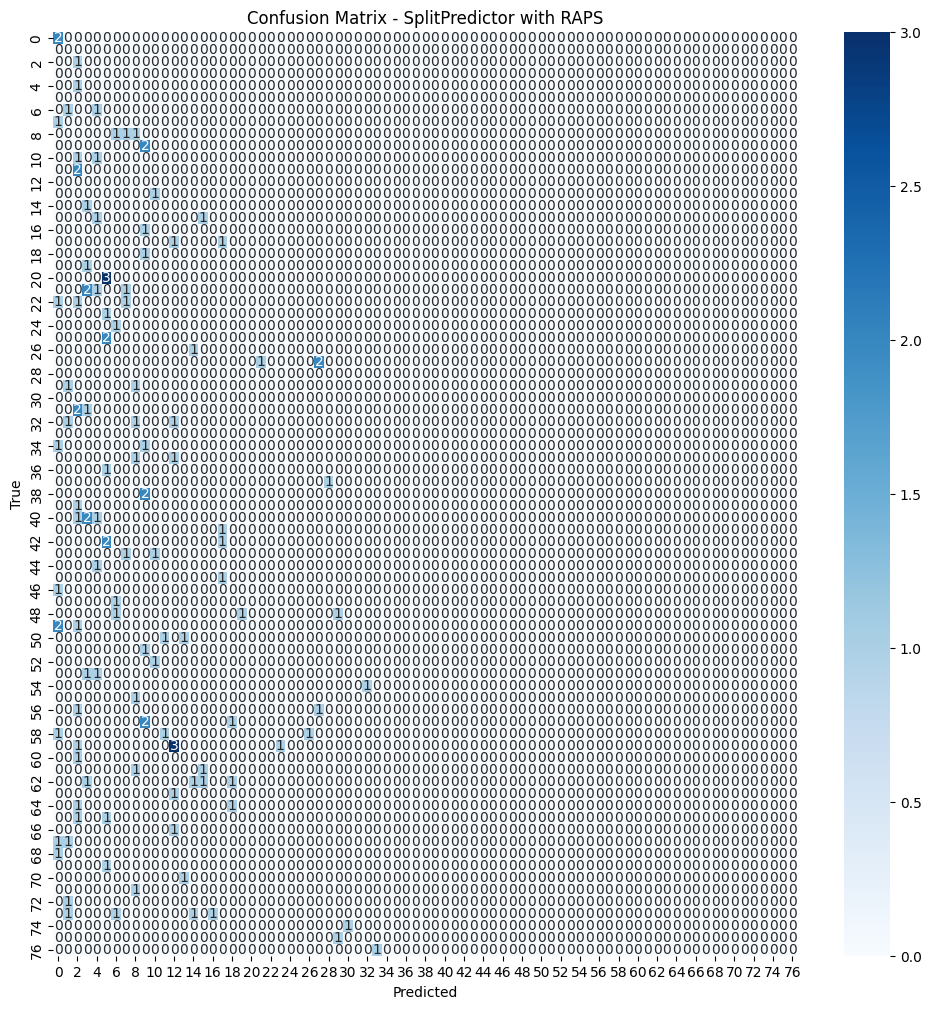

ClassWisePredictor with RAPS - Coverage Rate: 0.8969, Average Set Size: 11.1982


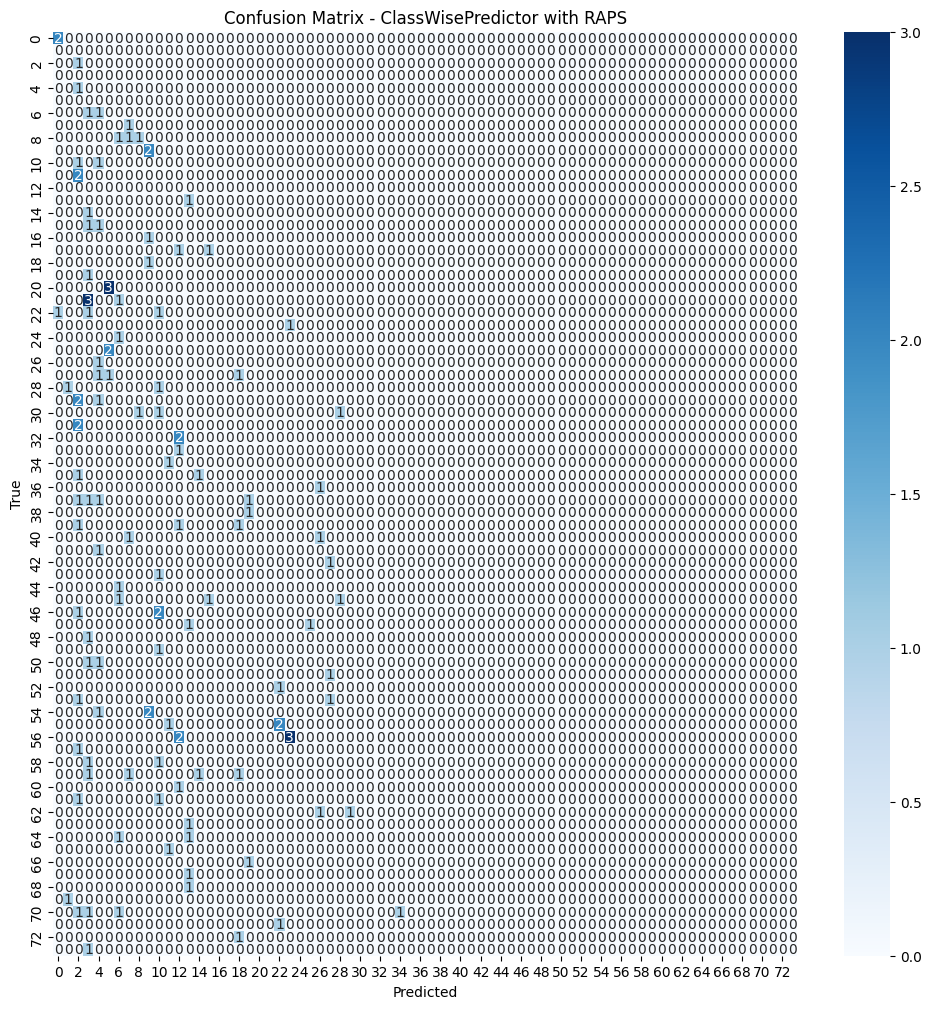

ClusterPredictor with RAPS - Coverage Rate: 0.9044, Average Set Size: 11.3634


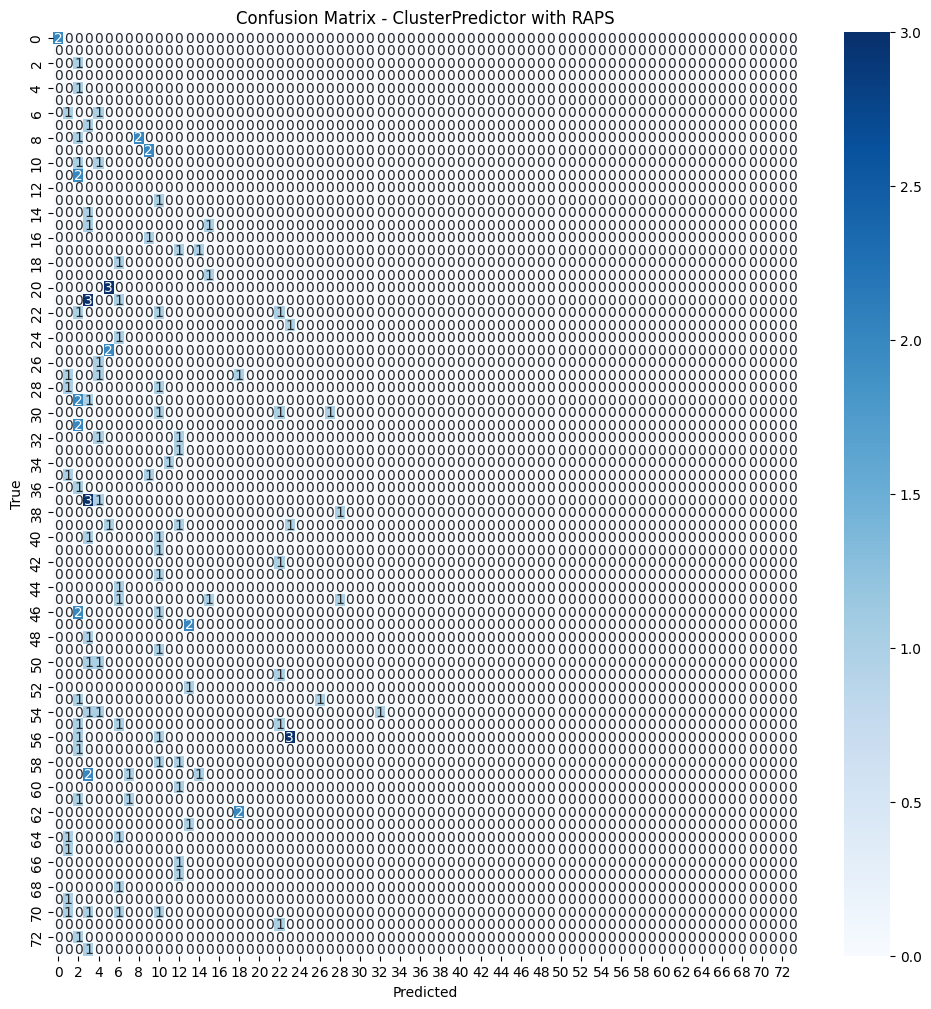

SplitPredictor with SAPS - Coverage Rate: 0.8996, Average Set Size: 10.2265


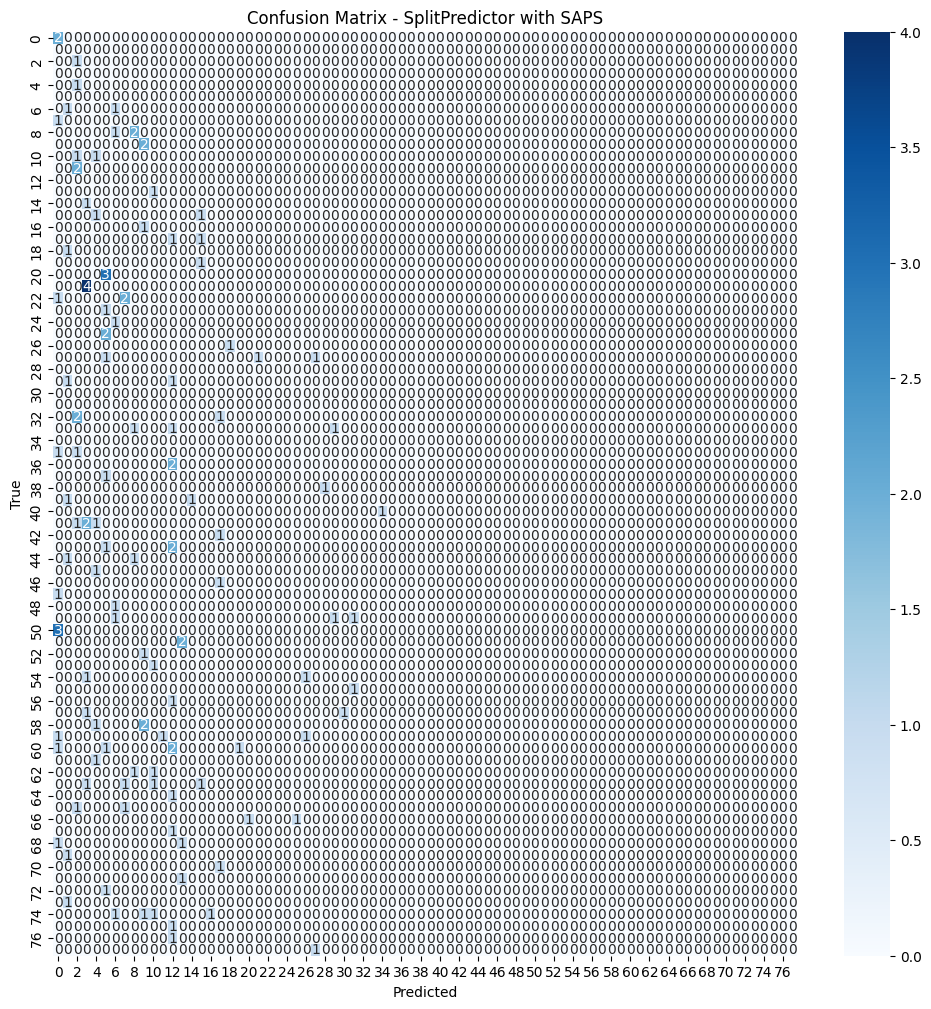

ClassWisePredictor with SAPS - Coverage Rate: 0.9009, Average Set Size: 12.1405


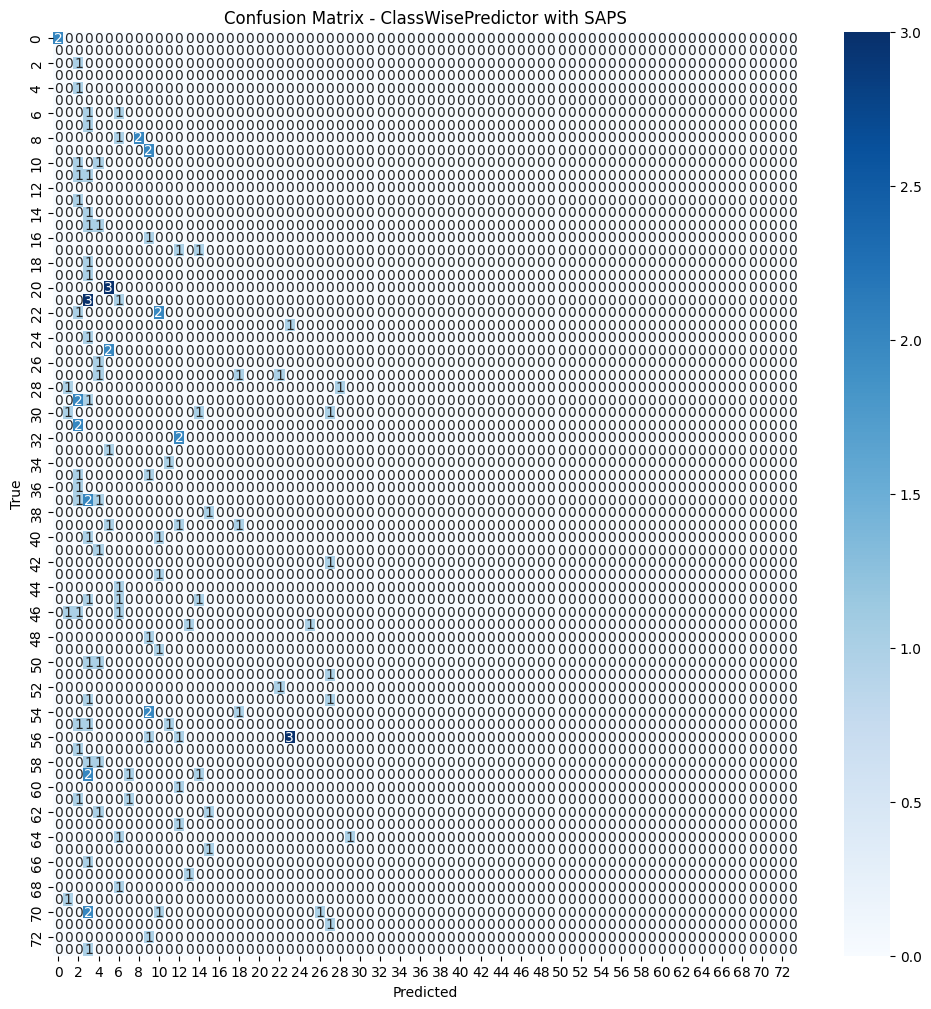

ClusterPredictor with SAPS - Coverage Rate: 0.9036, Average Set Size: 11.8488


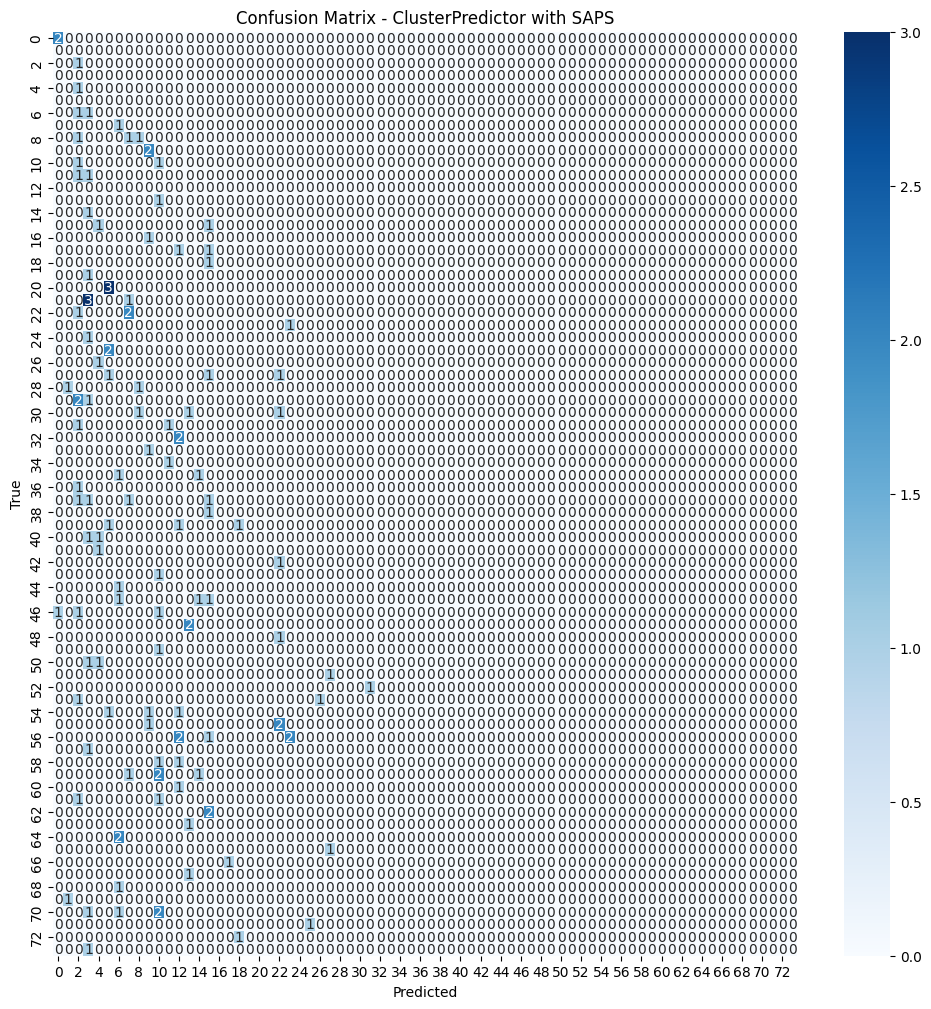

SplitPredictor with APS - Coverage Rate: 0.8999, Average Set Size: 9.738


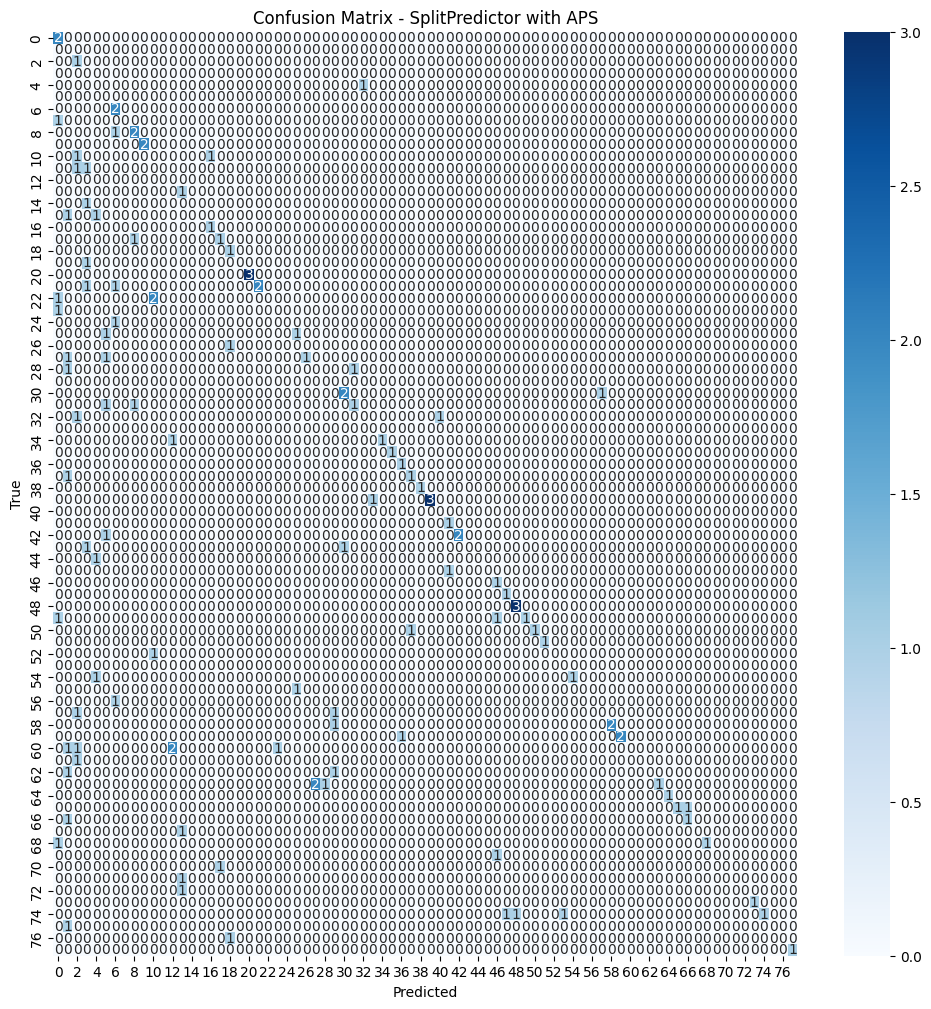

ClassWisePredictor with APS - Coverage Rate: 0.9012, Average Set Size: 11.0112


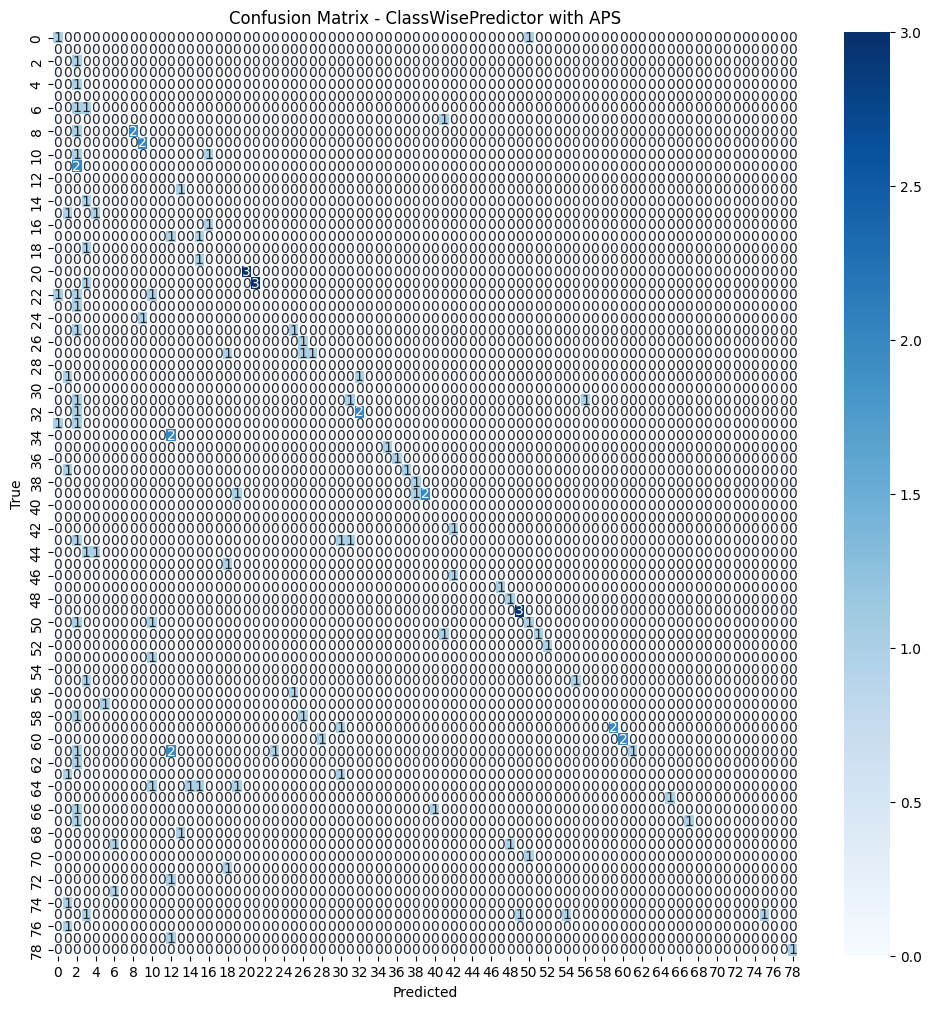

ClusterPredictor with APS - Coverage Rate: 0.8978, Average Set Size: 10.0939


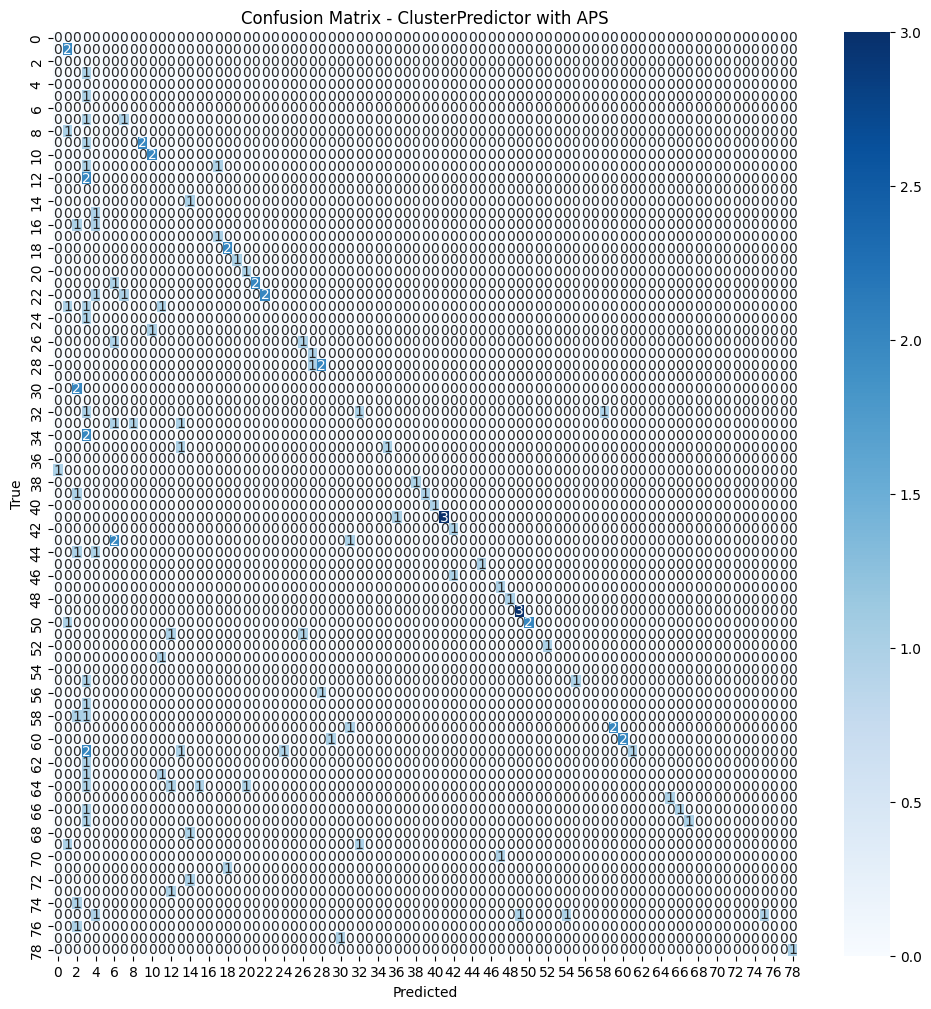

SplitPredictor with THR - Coverage Rate: 0.9003, Average Set Size: 8.1064


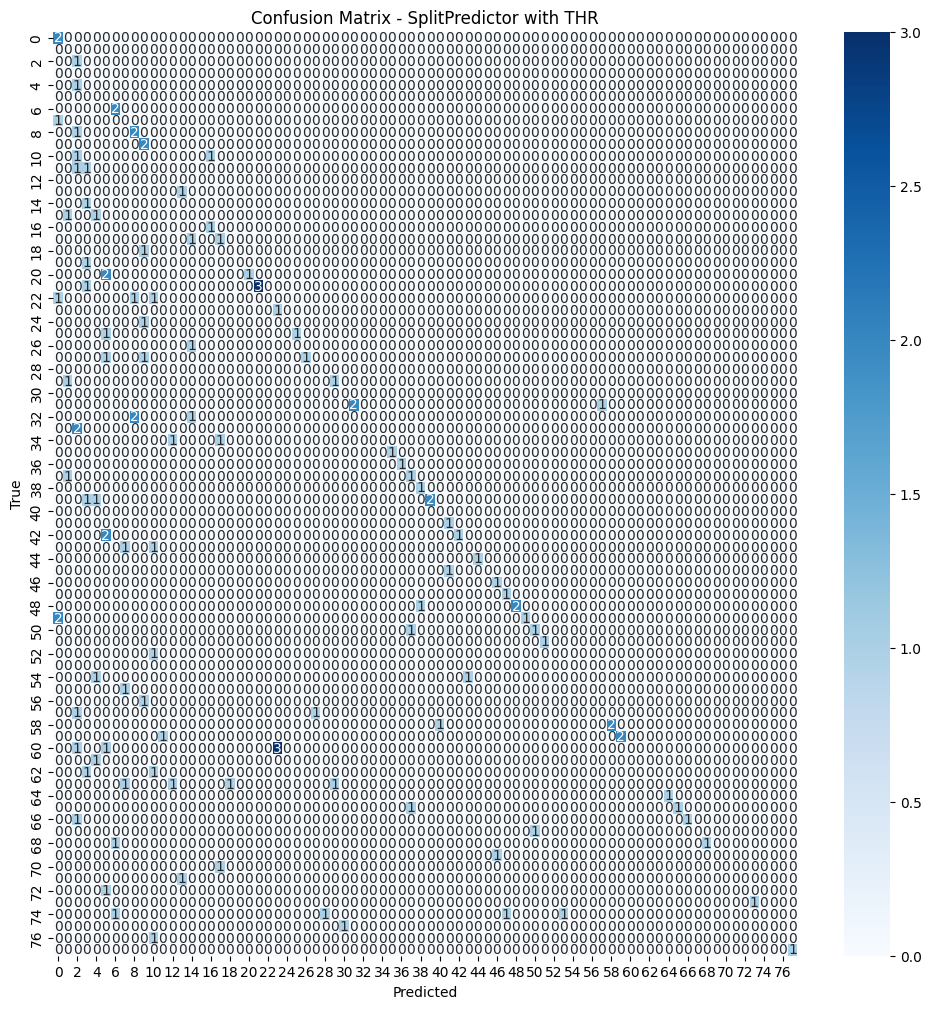

ClassWisePredictor with THR - Coverage Rate: 0.9074, Average Set Size: 9.4092


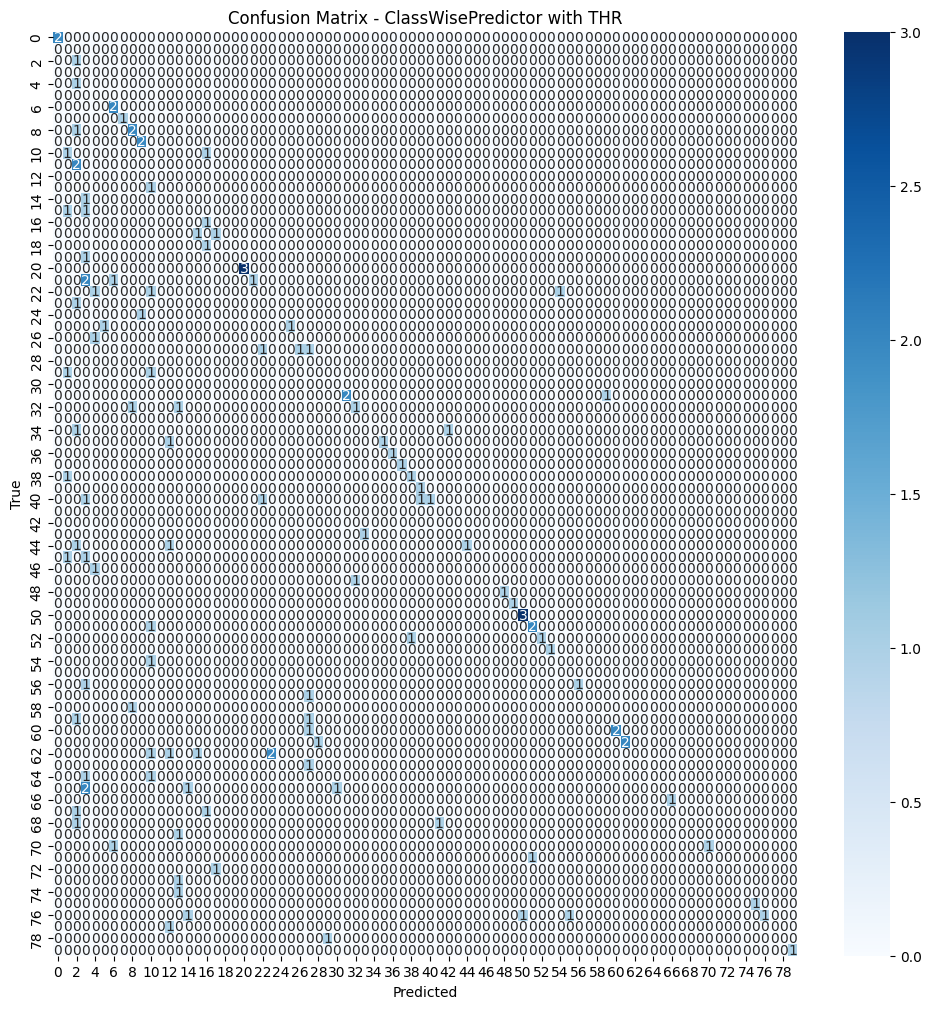

ClusterPredictor with THR - Coverage Rate: 0.9032, Average Set Size: 8.7124


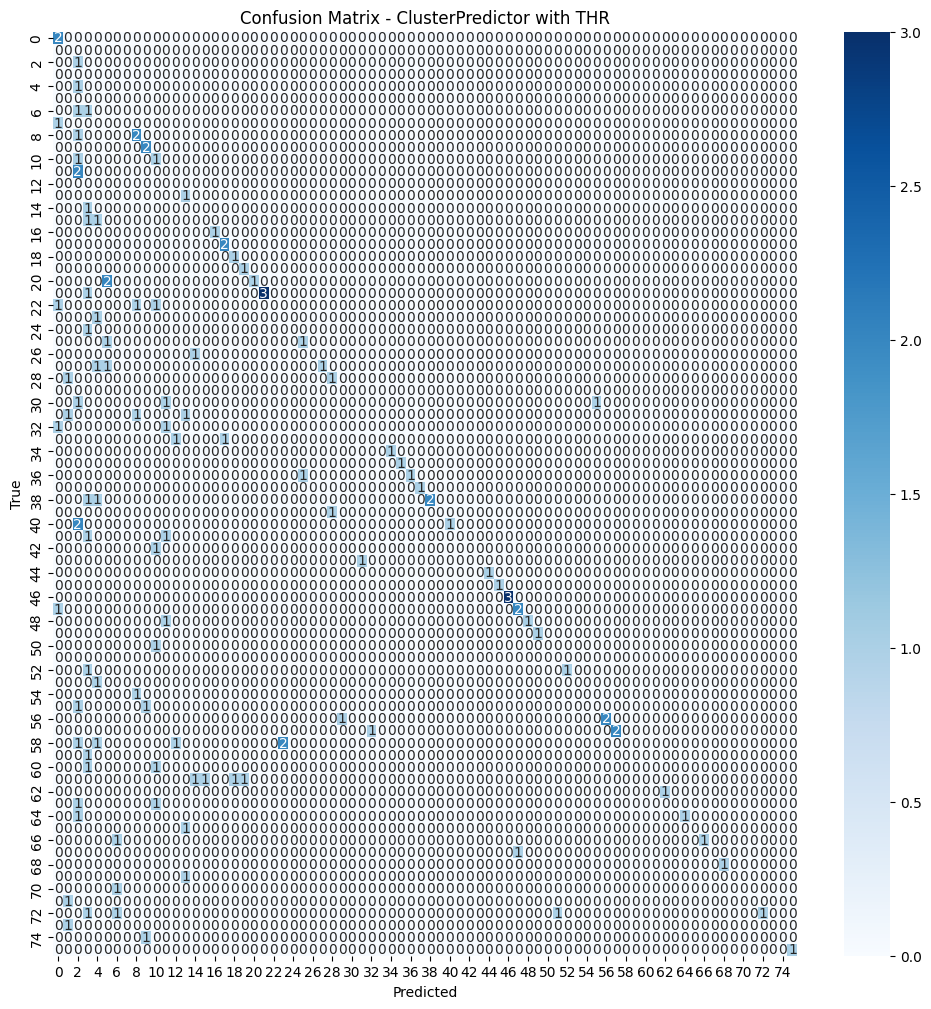

In [7]:
# 可视化结果
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 定义评分函数和预测器的映射
score_functions = {
    'RAPS': RAPS(penalty=1.0),
    'SAPS': SAPS(weight=1.0),
    'APS': APS(),
    'THR': THR()
}

predictors = {
    'SplitPredictor': SplitPredictor,
    'ClassWisePredictor': ClassWisePredictor,
    'ClusterPredictor': ClusterPredictor
}

# 初始化存储结果的数组
coverage_rates = []
average_sizes = []
combination_labels = []

# 循环测试每个评分函数和预测器的组合
for score_name, score_func in score_functions.items():
    for predictor_name, Predictor in predictors.items():
        predictor = Predictor(score_function=score_func, model=model)

        # 校准预测器
        predictor.calibrate(cifar100_test_loader, alpha=0.1)

        all_predict_sets = []
        all_true_labels = []

        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in cifar100_test_loader:
                inputs = inputs.to(device)
                predict_sets = predictor.predict(inputs)
                all_predict_sets.extend(predict_sets)
                all_true_labels.extend(labels.cpu().numpy())

                # For simplicity, we use only one batch for demonstration
                break

        # Calculate coverage rate and average set size
        result_dict = predictor.evaluate(cifar100_test_loader)
        print(f'{predictor_name} with {score_name} - Coverage Rate: {result_dict["Coverage_rate"]}, Average Set Size: {result_dict["Average_size"]}')

        # 更新结果数组
        coverage_rates.append(result_dict["Coverage_rate"])
        average_sizes.append(result_dict["Average_size"])
        combination_labels.append(f'{predictor_name} with {score_name}')  # 使用更新后的变量名

        # Visualize the results
        single_predictions = [p[0] if p else -1 for p in all_predict_sets]  # Use -1 for empty sets
        cm = confusion_matrix(all_true_labels, single_predictions)

        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {predictor_name} with {score_name}')
        plt.show()

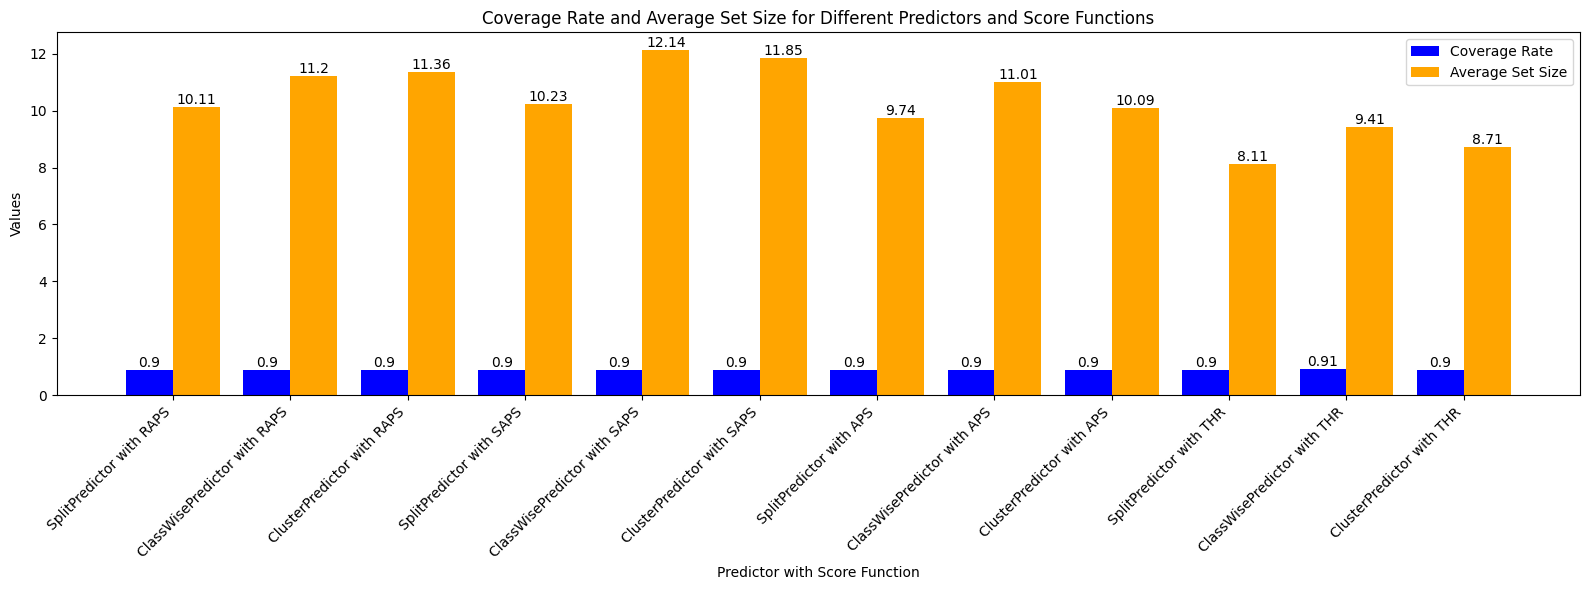

In [9]:
# 设置柱状图参数
x = range(len(combination_labels))  # 横坐标位置
width = 0.4  # 柱子的宽度

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x, coverage_rates, width, label='Coverage Rate', color='blue')
bars2 = ax.bar([p + width for p in x], average_sizes, width, label='Average Set Size', color='orange')

# 添加标签和标题
ax.set_xlabel('Predictor with Score Function')
ax.set_ylabel('Values')
ax.set_title('Coverage Rate and Average Set Size for Different Predictors and Score Functions')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(combination_labels, rotation=45, ha='right')
ax.legend()

# 在柱状图上添加数据标签
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# 显示图表
plt.tight_layout()
plt.show()